In [103]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LayerNormalization, BatchNormalization, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
os.chdir('C:\\Users\\Jacob\\Desktop\\Purdue MSBAIM\\Module 3\\MGMT 59000 - Machine Learning\\Final Project\\g-research-crypto-forecasting')

In [188]:
# Load In Data
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('supplemental_train.csv')
df = pd.concat([df1, df2], ignore_index = True)
del df1
del df2

# Graphs for Slideshow

<Figure size 3600x720 with 0 Axes>

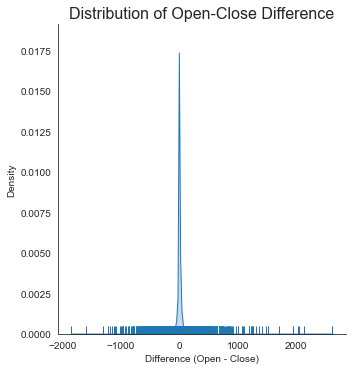

In [212]:
import seaborn as sns
import matplotlib.pyplot as plt
df = df[df['Asset_ID'] ==1]
df['diff'] = df['Open'] - df['Close']
sns.set_style("white")
plt.figure(figsize=(50, 10))
sns.displot(df['diff'], kind = 'kde', rug = True, fill = True)

# Customize axis labels and title
plt.xlabel('Difference (Open - Close)')
plt.ylabel('Density')
plt.title('Distribution of Open-Close Difference', fontsize=16)
plt.show()

<Figure size 864x1800 with 0 Axes>

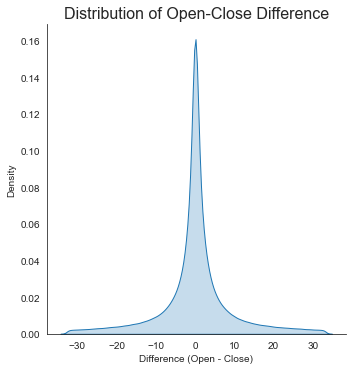

In [213]:
# Remove top 5 and bottom 5%
bottom_percentile = df['diff'].quantile(.05)
top_percentile = df['diff'].quantile(.95)
filtered_df = df[(df['diff'] >= bottom_percentile) & (df['diff'] <= top_percentile)]
plt.figure(figsize=(12, 25))
sns.displot(filtered_df['diff'], kind = 'kde', fill = True)
plt.xlabel('Difference (Open - Close)')
plt.ylabel('Density')
plt.title('Distribution of Open-Close Difference', fontsize=16)
plt.show()

<Figure size 864x1800 with 0 Axes>

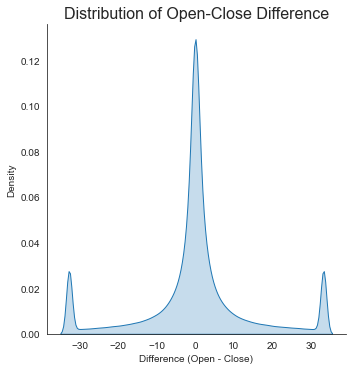

In [228]:
df1 = df[:]
df1.loc[df['diff'] < bottom_percentile, 'diff'] = bottom_percentile
df1.loc[df['diff'] > top_percentile, 'diff'] = top_percentile
plt.figure(figsize=(12, 25))
sns.displot(df1['diff'], kind = 'kde', fill = True)
plt.xlabel('Difference (Open - Close)')
plt.ylabel('Density')
plt.title('Distribution of Open-Close Difference', fontsize=16)
plt.show()

In [229]:
m1TI = 2887852.05
m1NG = 48314.59
m1PG = 1.67
m1TMAE = 11.715
m1RLTMAE = 25.521

In [230]:
m2TI = 2926220.53
m2NG = 40980.51
m2PG = 1.4
m2TMAE = 15.166
m2RLTMAE = 26.011

In [231]:
m3TI = 2598895.22
m3NG = 15560.04
m3PG = .6
m3TMAE = 13.902
m3RLTMAE = 29.73

Text(0.5, 1.0, 'Test Mean Absolute Error for Each Model')

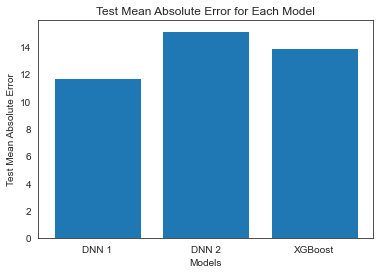

In [225]:
models = ['DNN 1', 'DNN 2', 'XGBoost']
TMAE = [m1TMAE, m2TMAE, m3TMAE]
plt.bar(models, TMAE)
plt.xlabel('Models')
plt.ylabel('Test Mean Absolute Error')
plt.title('Test Mean Absolute Error for Each Model')

Text(0.5, 1.0, 'Test Mean Absolute Error for Each Model')

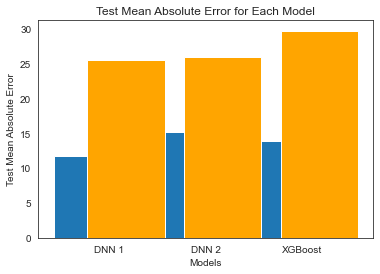

In [232]:
models = ['DNN 1', 'DNN 2', 'XGBoost']
TMAE = [m1TMAE, m2TMAE, m3TMAE]
RLTMAE = [m1RLTMAE, m2RLTMAE, m3RLTMAE]

bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

plt.bar(r1, TMAE)
plt.bar(r2, RLTMAE, color = 'orange')
plt.xticks([r + bar_width / 2 for r in range(len(models))], models)
plt.xlabel('Models')
plt.ylabel('Test Mean Absolute Error')
plt.title('Test Mean Absolute Error for Each Model')

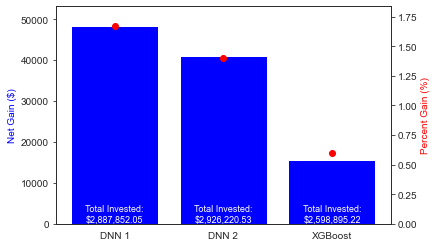

In [248]:
TI = [m1TI, m2TI, m3TI]
NG = [m1NG, m2NG, m3NG]
PG = [m1PG, m2PG, m3PG]
# Create figure and axis objects
# Create figure and axis objects
fig, ax1 = plt.subplots()

# Bar chart for net gain
ax1.bar(models, NG, color='blue')
ax1.set_ylabel('Net Gain ($)', color='blue')
ax1.set_ylim(0, max(NG) * 1.1)  # Adjust left y-scale to start from 0

# Plotting total invested under each model name
for i, model in enumerate(models):
    # Splitting text into multiple lines for wrapping
    ti_text = f'Total Invested:\n${TI[i]:,.2f}'
    ax1.text(model, 0, ti_text, ha='center', va='bottom', fontsize=9, color='white')    # Change font color to white

# Twin the y-axis for percentage gain
ax2 = ax1.twinx()
ax2.plot(models, PG, marker='o', color='red', linestyle='')
ax2.set_ylabel('Percent Gain (%)', color='red')
ax2.set_ylim(0, max(PG) * 1.1)

# Remove the text near the points
for text in ax2.texts:
    text.set_visible(False)

plt.show()

# Preprocessing

In [157]:
# Change Timestamp to something readible
df['timestamp'] = df['timestamp'].astype('datetime64[s]')

In [136]:
# Check for Missing Values
df.isna().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       753261
dtype: int64

In [158]:
# VWAP Missing Values
print(df[df['VWAP'].isna()])
# Missing bcs no trading occured, can fill in with zero
df['VWAP'].fillna(0, inplace=True)

                   timestamp  Asset_ID  Count    Open    High     Low   Close  \
15004269 2020-06-14 22:26:00        10    2.0  501.00  501.00  501.00  501.00   
15004283 2020-06-14 22:27:00        10    4.0  501.00  501.00  501.00  501.00   
15059232 2020-06-17 20:36:00        10    2.0  529.77  529.77  529.77  529.77   
15143187 2020-06-22 11:02:00        10    2.0  503.60  503.60  503.60  503.60   
15183088 2020-06-24 14:29:00        10    2.0  484.16  484.16  484.16  484.16   
15184216 2020-06-24 15:52:00        10    2.0  480.00  480.00  480.00  480.00   
15184243 2020-06-24 15:54:00        10    2.0  480.00  480.00  480.00  480.00   
15184309 2020-06-24 15:59:00        10    6.0  479.07  479.07  479.07  479.07   
15184778 2020-06-24 16:34:00        10    4.0  478.00  478.00  475.00  478.00   

          Volume  VWAP    Target  
15004269     0.0   NaN       NaN  
15004283     0.0   NaN       NaN  
15059232     0.0   NaN  0.007356  
15143187     0.0   NaN -0.005672  
15183088     0

In [159]:
# Just decided to drop all target values that are missing
df.dropna(subset=['Target'], inplace=True)

# JUST FOR BTC

In [160]:
df = df[df['Asset_ID'] ==1]

# Import Additional Datasets

In [161]:
FGIDX = pd.read_csv('FearGreed.csv')

In [162]:
FGIDX = FGIDX.rename(columns={'value':'FGIDX value'})

FGIDX['Date'] = pd.to_datetime(FGIDX['Date'])
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df['date'] = pd.to_datetime(df['date'])
                            
df = pd.merge(df,FGIDX, left_on = 'date', right_on = 'Date', how = 'inner')
del FGIDX

In [163]:
df.drop(columns = ['Date', 'date'], inplace = True)
df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Value
0,2018-02-01 00:01:00,1,837.0,10193.066667,10299.99,10060.30,10161.078333,121.422898,10171.013711,-0.002058,30.0
1,2018-02-01 00:02:00,1,464.0,10161.303333,10284.42,10069.47,10184.276667,50.727881,10172.967171,-0.001449,30.0
2,2018-02-01 00:03:00,1,285.0,10187.751667,10283.98,10077.50,10191.456667,48.684638,10186.707119,-0.002957,30.0
3,2018-02-01 00:04:00,1,657.0,10189.543783,10283.97,10087.00,10203.481667,113.806416,10196.464324,-0.002697,30.0
4,2018-02-01 00:05:00,1,612.0,10201.956667,10304.24,10099.90,10225.586667,136.991385,10220.242614,-0.002808,30.0


# Feature Engineering

In [164]:
# Asset Returns
# Specify the list of time intervals in minutes
time_intervals = [1, 2, 3, 5, 10, 15, 20, 30, 40, 50, 60]

# Calculate asset return for each time interval and add to DataFrame
for interval in time_intervals:
    col_name = f'asset_return_{interval}min'
    # Shift the 'Close' prices by the interval to get the previous prices
    previous_close_prices = df['Close'].shift(interval)
    # Calculate the asset return based on the previous closing prices
    df[col_name] = (df['Close'] - previous_close_prices) / previous_close_prices * 100

In [165]:
# Specify the list of moving average window sizes in minutes
moving_average_windows = [5, 10, 15, 20, 30, 40, 50, 60]

# Calculate asset return for each time interval and add to DataFrame
for window in moving_average_windows:
    col_name = f'asset_return_ma_{window}min'
    # Calculate the moving average of asset return using rolling window
    df[col_name] = df['Close'].pct_change().shift(1).rolling(window=window).mean() * 100

In [166]:
df = df.dropna()

In [115]:
df['Target'] = df['Close'] - df['Open']

# Model Building - DNN

In [167]:
# Select Features
selected_df = df[['asset_return_1min', 'asset_return_2min', 'asset_return_3min', 'asset_return_5min',
        'asset_return_10min', 'asset_return_15min', 'asset_return_20min',
        'asset_return_30min', 'asset_return_40min', 'asset_return_50min',
        'asset_return_60min', 'asset_return_ma_5min', 'asset_return_ma_10min',
        'asset_return_ma_15min', 'asset_return_ma_20min',
        'asset_return_ma_30min', 'asset_return_ma_40min',
        'asset_return_ma_50min', 'asset_return_ma_60min', 'Value', 'Target']]

# Remove top 5 and bottom 5%
bottom_percentile = selected_df['Target'].quantile(.05)
top_percentile = selected_df['Target'].quantile(.95)
filtered_df = selected_df[(selected_df['Target'] >= bottom_percentile) & (selected_df['Target'] <= top_percentile)]

# Select Features
X_DNN = filtered_df[['asset_return_1min', 'asset_return_2min', 'asset_return_3min', 'asset_return_5min',
        'asset_return_10min', 'asset_return_15min', 'asset_return_20min',
        'asset_return_30min', 'asset_return_40min', 'asset_return_50min',
        'asset_return_60min', 'asset_return_ma_5min', 'asset_return_ma_10min',
        'asset_return_ma_15min', 'asset_return_ma_20min',
        'asset_return_ma_30min', 'asset_return_ma_40min',
        'asset_return_ma_50min', 'asset_return_ma_60min', 'Value']]
y_DNN = filtered_df['Target']



In [168]:
# Determine the indices for splitting
train_size = int(0.7 * len(filtered_df))
val_size = int(0.1 * len(filtered_df))

# Split the data 
train_X = X_DNN[:train_size]
train_y = y_DNN[:train_size]
val_X = X_DNN[train_size:train_size+val_size]
val_y = y_DNN[train_size:train_size+val_size]
test_X = X_DNN[train_size+val_size:]
test_y = y_DNN[train_size+val_size:]



In [169]:
model1 = keras.Sequential()
model1.add(layers.Dense(2048, activation = 'relu', input_shape=(len(X_DNN.columns),)))
model1.add(layers.Dense(256))
model1.add(layers.Dense(64))
model1.add(layers.Dense(1, activation = 'linear'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2048)              43008     
                                                                 
 dense_5 (Dense)             (None, 256)               524544    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 584,065
Trainable params: 584,065
Non-trainable params: 0
_________________________________________________________________


In [170]:
# Remove top and bottom 5%
model1.compile(optimizer=keras.optimizers.RMSprop(0.0001), loss = 'mae', metrics = ['mae'])

EPOCHS = 100

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


history = model1.fit(train_X, train_y,
                    batch_size=128, epochs=EPOCHS,
                    validation_data=(val_X, val_y),
                    callbacks=[early_stop])

Epoch 1/100
10272/10272 [==============================] - 103s 10ms/step - loss: 0.0932 - mae: 0.0932 - val_loss: 0.0014 - val_mae: 0.0014
Epoch 2/100
10272/10272 [==============================] - 3272s 319ms/step - loss: 0.0025 - mae: 0.0025 - val_loss: 0.0011 - val_mae: 0.0011
Epoch 3/100
10272/10272 [==============================] - 94s 9ms/step - loss: 0.0012 - mae: 0.0012 - val_loss: 0.0012 - val_mae: 0.0012
Epoch 4/100
10272/10272 [==============================] - 94s 9ms/step - loss: 8.6360e-04 - mae: 8.6360e-04 - val_loss: 0.0011 - val_mae: 0.0011
Epoch 5/100
10272/10272 [==============================] - 89s 9ms/step - loss: 8.1059e-04 - mae: 8.1059e-04 - val_loss: 0.0010 - val_mae: 0.0010
Epoch 6/100
10272/10272 [==============================] - 90s 9ms/step - loss: 7.9899e-04 - mae: 7.9899e-04 - val_loss: 0.0010 - val_mae: 0.0010
Epoch 7/100
10272/10272 [==============================] - 90s 9ms/step - loss: 7.9627e-04 - mae: 7.9627e-04 - val_loss: 0.0010 - val_mae: 0.0

In [171]:
# Evaluate the model on the test set
loss, mae = model1.evaluate(test_X, test_y, verbose=0)

# Print the evaluation results
print("Testing set MAE:", mae)

Testing set MAE: 0.0008843788527883589


In [172]:
predictions = model1.predict(test_X)
predictions

array([[-1.7922105e-04],
       [-2.0007647e-04],
       [-1.9966415e-04],
       ...,
       [-1.8770868e-05],
       [-2.3252453e-05],
       [-2.0356527e-05]], dtype=float32)

In [ ]:
# FOR DNN WITH VARIABLE REPLACEMENT

In [333]:
# For DNN
selected_df = df[['asset_return_1min', 'asset_return_2min', 'asset_return_3min', 'asset_return_5min',
        'asset_return_10min', 'asset_return_15min', 'asset_return_20min',
        'asset_return_30min', 'asset_return_40min', 'asset_return_50min',
        'asset_return_60min', 'asset_return_ma_5min', 'asset_return_ma_10min',
        'asset_return_ma_15min', 'asset_return_ma_20min',
        'asset_return_ma_30min', 'asset_return_ma_40min',
        'asset_return_ma_50min', 'asset_return_ma_60min', 'Value', 'Target']]

bottom_quantile = selected_df['Target'].quantile(.05)
top_quantile = selected_df['Target'].quantile(.95)
selected_df.loc[selected_df['Target'] < bottom_quantile, 'Target'] = bottom_quantile
selected_df.loc[selected_df['Target'] > top_quantile, 'Target'] = top_quantile

X_DNN = selected_df[['asset_return_1min', 'asset_return_2min', 'asset_return_3min', 'asset_return_5min',
        'asset_return_10min', 'asset_return_15min', 'asset_return_20min',
        'asset_return_30min', 'asset_return_40min', 'asset_return_50min',
        'asset_return_60min', 'asset_return_ma_5min', 'asset_return_ma_10min',
        'asset_return_ma_15min', 'asset_return_ma_20min',
        'asset_return_ma_30min', 'asset_return_ma_40min',
        'asset_return_ma_50min', 'asset_return_ma_60min', 'Value']]
y = selected_df['Target']



C:\Users\Jacob\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Jacob\anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [334]:
# Determine the indices for splitting
train_size = int(0.7 * len(selected_df))
val_size = int(0.1 * len(selected_df))

# Split the data 
train_X = X_DNN[:train_size]
train_y = y[:train_size]
val_X = X_DNN[train_size:train_size+val_size]
val_y = y[train_size:train_size+val_size]
test_X = X_DNN[train_size+val_size:]
test_y = y[train_size+val_size:]



In [318]:
model2 = keras.Sequential()
model2.add(layers.Dense(2048, activation = 'relu', input_shape=(len(X_DNN.columns),)))
model2.add(layers.Dense(256))
model2.add(layers.Dense(64))
model2.add(layers.Dense(1))
model2.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 2048)              43008     
                                                                 
 dense_63 (Dense)            (None, 256)               524544    
                                                                 
 dense_64 (Dense)            (None, 64)                16448     
                                                                 
 dense_65 (Dense)            (None, 1)                 65        
                                                                 
Total params: 584,065
Trainable params: 584,065
Non-trainable params: 0
_________________________________________________________________


In [319]:
# Transform bottom and top 5% to value at quantile.
model2.compile(optimizer=keras.optimizers.RMSprop(0.0001), loss = 'mae', metrics = ['mae'])

EPOCHS = 100

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


history = model2.fit(train_X, train_y,
                    batch_size=128, epochs=EPOCHS,
                    validation_data=(val_X, val_y),
                    callbacks=[early_stop])

Epoch 1/100
11413/11413 [==============================] - 217s 19ms/step - loss: 2.5004 - mae: 2.5004 - val_loss: 13.5864 - val_mae: 13.5864
Epoch 2/100
11413/11413 [==============================] - 220s 19ms/step - loss: 2.0380 - mae: 2.0380 - val_loss: 12.1774 - val_mae: 12.1774
Epoch 3/100
11413/11413 [==============================] - 221s 19ms/step - loss: 1.8415 - mae: 1.8415 - val_loss: 12.6372 - val_mae: 12.6372
Epoch 4/100
11413/11413 [==============================] - 220s 19ms/step - loss: 1.7982 - mae: 1.7982 - val_loss: 11.9553 - val_mae: 11.9553
Epoch 5/100
11413/11413 [==============================] - 221s 19ms/step - loss: 1.7775 - mae: 1.7775 - val_loss: 11.7635 - val_mae: 11.7635
Epoch 6/100
11413/11413 [==============================] - 223s 20ms/step - loss: 1.7646 - mae: 1.7646 - val_loss: 12.0574 - val_mae: 12.0574
Epoch 7/100
11413/11413 [==============================] - 221s 19ms/step - loss: 1.7536 - mae: 1.7536 - val_loss: 11.3131 - val_mae: 11.3131
Epoch 

In [335]:
loss, mae = model2.evaluate(test_X, test_y, verbose=0)

# Print the evaluation results
print("Testing set MAE:", mae)

Testing set MAE: 15.166011810302734


# Portfolio Testing

In [173]:
# Select Features
selected_df = df[['asset_return_1min', 'asset_return_2min', 'asset_return_3min', 'asset_return_5min',
        'asset_return_10min', 'asset_return_15min', 'asset_return_20min',
        'asset_return_30min', 'asset_return_40min', 'asset_return_50min',
        'asset_return_60min', 'asset_return_ma_5min', 'asset_return_ma_10min',
        'asset_return_ma_15min', 'asset_return_ma_20min',
        'asset_return_ma_30min', 'asset_return_ma_40min',
        'asset_return_ma_50min', 'asset_return_ma_60min', 'Value', 'Target', 'Open', 'Close']]

# Select Features
X_Port = selected_df[['asset_return_1min', 'asset_return_2min', 'asset_return_3min', 'asset_return_5min',
        'asset_return_10min', 'asset_return_15min', 'asset_return_20min',
        'asset_return_30min', 'asset_return_40min', 'asset_return_50min',
        'asset_return_60min', 'asset_return_ma_5min', 'asset_return_ma_10min',
        'asset_return_ma_15min', 'asset_return_ma_20min',
        'asset_return_ma_30min', 'asset_return_ma_40min',
        'asset_return_ma_50min', 'asset_return_ma_60min', 'Value', 'Open', 'Close']]
y_Port = selected_df['Target']

# Determine the indices for splitting
train_size = int(0.7 * len(selected_df))
val_size = int(0.1 * len(selected_df))

# Split the data 
train_X = X_Port[:train_size]
train_y = y_Port[:train_size]
val_X = X_Port[train_size:train_size+val_size]
val_y = y_Port[train_size:train_size+val_size]
test_X = X_Port[train_size+val_size:]
test_y = y_Port[train_size+val_size:]

In [174]:
# If you're wondering, I just changed this code and updated the predictions each time
predictions = model1.predict(test_X.iloc[:, :-2])
predictions1 = model2.predict
predictions

array([[ 2.8632998e-05],
       [ 1.0256225e-04],
       [ 7.1827104e-05],
       ...,
       [-1.8770823e-05],
       [-2.3252434e-05],
       [-2.0356527e-05]], dtype=float32)

In [175]:
# Determine the indices for splitting
train_size = int(0.7 * len(df))
val_size = int(0.1 * len(df))

y = df['Target']


# Split the data 
train_X = df[:train_size]
train_y = df[:train_size]
val_X = df[train_size:train_size+val_size]
val_y = df[train_size:train_size+val_size]
test_X = df[train_size+val_size:]
test_y = df[train_size+val_size:]

In [176]:
open_prices = test_X['Open']
close_prices = test_X['Close']

In [125]:
def simulate_trading(predictions, open_prices, close_prices):
    
    # Calculate predicted percentage changes
    predicted_percentage_changes = [(prediction / open_price) * 100 if open_price != 0 else 0 for prediction, open_price in zip(predictions, open_prices)]
    
    # Determine indices for top .01% and bottom .01% changes
    num_trades = int(len(predictions) * .0001)
    sorted_indices = sorted(range(len(predicted_percentage_changes)), key=lambda i: predicted_percentage_changes[i])
    top_10_percent_indices = sorted_indices[-num_trades:]
    bottom_10_percent_indices = sorted_indices[:num_trades]
    
    net_gain = 0.0
    total_invested = 0.0
    
    # Buy for the top .01% predictions
    for i in top_10_percent_indices:
        open_price = open_prices.iloc[i]
        close_price = close_prices.iloc[i]
        net_gain += (close_price - open_price)  # Gain from buying at open and selling at close
        total_invested += open_price  # Cost of buying
    
    # Short sell for the bottom .01% predictions
    for i in bottom_10_percent_indices:
        open_price = open_prices.iloc[i]
        close_price = close_prices.iloc[i]
        net_gain += (open_price - close_price)  # Gain from short selling at open and buying to cover at close
        total_invested += open_price  # Cost of short selling (equivalent to buying)
    
    percent_gained = (net_gain / total_invested) * 100 if total_invested > 0 else 0
    
    return net_gain, total_invested, percent_gained

In [177]:
# For DNN 1
print(simulate_trading(predictions, open_prices, close_prices))

(-14251.040405090924, 3039805.626576782, -0.46881419918744793)


In [351]:
# For DNN 2
print(simulate_trading(predictions1, open_prices, close_prices))

(48314.58948368164, 2887852.0522640157, 1.673028555801673)


In [16]:
import pandas as pd
from xgboost import XGBRegressor

In [79]:
# Select Features
selected_df = df[['asset_return_1min', 'asset_return_2min', 'asset_return_3min', 'asset_return_5min',
        'asset_return_10min', 'asset_return_15min', 'asset_return_20min',
        'asset_return_30min', 'asset_return_40min', 'asset_return_50min',
        'asset_return_60min', 'asset_return_ma_5min', 'asset_return_ma_10min',
        'asset_return_ma_15min', 'asset_return_ma_20min',
        'asset_return_ma_30min', 'asset_return_ma_40min',
        'asset_return_ma_50min', 'asset_return_ma_60min', 'Value', 'Target']]
selected_df = selected_df.dropna()

# Remove top 5 and bottom 5%
bottom_percentile = selected_df['Target'].quantile(.05)
top_percentile = selected_df['Target'].quantile(.95)
filtered_df = selected_df[(selected_df['Target'] >= bottom_percentile) & (selected_df['Target'] <= top_percentile)]
X_XGB = filtered_df[['asset_return_1min', 'asset_return_2min', 'asset_return_3min', 'asset_return_5min',
        'asset_return_10min', 'asset_return_15min', 'asset_return_20min',
        'asset_return_30min', 'asset_return_40min', 'asset_return_50min',
        'asset_return_60min', 'asset_return_ma_5min', 'asset_return_ma_10min',
        'asset_return_ma_15min', 'asset_return_ma_20min',
        'asset_return_ma_30min', 'asset_return_ma_40min',
        'asset_return_ma_50min', 'asset_return_ma_60min', 'Value']]
y_XGB = filtered_df['Target']

In [80]:
# Determine the indices for splitting
train_size = int(0.7 * len(filtered_df))
val_size = int(0.1 * len(filtered_df))

# Split the data 
train_X = X_XGB[:train_size]
train_y = y_XGB[:train_size]
val_X = X_XGB[train_size:train_size+val_size]
val_y = y_XGB[train_size:train_size+val_size]
test_X = X_XGB[train_size+val_size:]
test_y = y_XGB[train_size+val_size:]



In [81]:
xgb = XGBRegressor(objective='reg:squarederror', n_estimators = 1000, learning_rate = .01, max_depth = 11)

#param_grid = {
   # 'n_estimators': [100, 200, 300],  # Number of boosting rounds
  #  'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
  # 'max_depth': [3, 4, 5]  # Maximum depth of a tree
#}

# Fit the model with early stopping
xgb.fit(train_X, train_y, early_stopping_rounds=4, eval_set=[(val_X, val_y)], eval_metric='mae', verbose=True)

[0]	validation_0-mae:5.51668
[1]	validation_0-mae:5.48256
[2]	validation_0-mae:5.44883
[3]	validation_0-mae:5.41546
[4]	validation_0-mae:5.38238
[5]	validation_0-mae:5.34971
[6]	validation_0-mae:5.31737
[7]	validation_0-mae:5.28537
[8]	validation_0-mae:5.25354
[9]	validation_0-mae:5.22234
[10]	validation_0-mae:5.19118
[11]	validation_0-mae:5.16035
[12]	validation_0-mae:5.12981
[13]	validation_0-mae:5.09966
[14]	validation_0-mae:5.06977
[15]	validation_0-mae:5.04023
[16]	validation_0-mae:5.01110
[17]	validation_0-mae:4.98193
[18]	validation_0-mae:4.95337
[19]	validation_0-mae:4.92509
[20]	validation_0-mae:4.89712
[21]	validation_0-mae:4.86948
[22]	validation_0-mae:4.84168
[23]	validation_0-mae:4.81454
[24]	validation_0-mae:4.78784
[25]	validation_0-mae:4.76135
[26]	validation_0-mae:4.73480
[27]	validation_0-mae:4.70860
[28]	validation_0-mae:4.68267
[29]	validation_0-mae:4.65732
[30]	validation_0-mae:4.63219
[31]	validation_0-mae:4.60707
[32]	validation_0-mae:4.58218
[33]	validation_0-ma

[268]	validation_0-mae:2.44887
[269]	validation_0-mae:2.44670
[270]	validation_0-mae:2.44441
[271]	validation_0-mae:2.44245
[272]	validation_0-mae:2.44060
[273]	validation_0-mae:2.43834
[274]	validation_0-mae:2.43637
[275]	validation_0-mae:2.43445
[276]	validation_0-mae:2.43230
[277]	validation_0-mae:2.43049
[278]	validation_0-mae:2.42877
[279]	validation_0-mae:2.42697
[280]	validation_0-mae:2.42536
[281]	validation_0-mae:2.42344
[282]	validation_0-mae:2.42172
[283]	validation_0-mae:2.41975
[284]	validation_0-mae:2.41812
[285]	validation_0-mae:2.41614
[286]	validation_0-mae:2.41445
[287]	validation_0-mae:2.41218
[288]	validation_0-mae:2.41048
[289]	validation_0-mae:2.40884
[290]	validation_0-mae:2.40721
[291]	validation_0-mae:2.40525
[292]	validation_0-mae:2.40372
[293]	validation_0-mae:2.40215
[294]	validation_0-mae:2.40071
[295]	validation_0-mae:2.39917
[296]	validation_0-mae:2.39743
[297]	validation_0-mae:2.39597
[298]	validation_0-mae:2.39429
[299]	validation_0-mae:2.39251
[300]	va

[533]	validation_0-mae:2.22833
[534]	validation_0-mae:2.22808
[535]	validation_0-mae:2.22795
[536]	validation_0-mae:2.22778
[537]	validation_0-mae:2.22766
[538]	validation_0-mae:2.22742
[539]	validation_0-mae:2.22730
[540]	validation_0-mae:2.22717
[541]	validation_0-mae:2.22699
[542]	validation_0-mae:2.22685
[543]	validation_0-mae:2.22670
[544]	validation_0-mae:2.22659
[545]	validation_0-mae:2.22648
[546]	validation_0-mae:2.22631
[547]	validation_0-mae:2.22617
[548]	validation_0-mae:2.22607
[549]	validation_0-mae:2.22597
[550]	validation_0-mae:2.22581
[551]	validation_0-mae:2.22572
[552]	validation_0-mae:2.22565
[553]	validation_0-mae:2.22559
[554]	validation_0-mae:2.22545
[555]	validation_0-mae:2.22535
[556]	validation_0-mae:2.22523
[557]	validation_0-mae:2.22501
[558]	validation_0-mae:2.22492
[559]	validation_0-mae:2.22480
[560]	validation_0-mae:2.22470
[561]	validation_0-mae:2.22463
[562]	validation_0-mae:2.22443
[563]	validation_0-mae:2.22435
[564]	validation_0-mae:2.22429
[565]	va

[798]	validation_0-mae:2.20588
[799]	validation_0-mae:2.20588
[800]	validation_0-mae:2.20585
[801]	validation_0-mae:2.20573
[802]	validation_0-mae:2.20573
[803]	validation_0-mae:2.20573
[804]	validation_0-mae:2.20573
[805]	validation_0-mae:2.20569
[806]	validation_0-mae:2.20567
[807]	validation_0-mae:2.20565
[808]	validation_0-mae:2.20566
[809]	validation_0-mae:2.20544
[810]	validation_0-mae:2.20543
[811]	validation_0-mae:2.20543
[812]	validation_0-mae:2.20543
[813]	validation_0-mae:2.20539
[814]	validation_0-mae:2.20535
[815]	validation_0-mae:2.20507
[816]	validation_0-mae:2.20507
[817]	validation_0-mae:2.20505
[818]	validation_0-mae:2.20504
[819]	validation_0-mae:2.20504
[820]	validation_0-mae:2.20485
[821]	validation_0-mae:2.20485
[822]	validation_0-mae:2.20485
[823]	validation_0-mae:2.20484
[824]	validation_0-mae:2.20484
[825]	validation_0-mae:2.20481
[826]	validation_0-mae:2.20481
[827]	validation_0-mae:2.20481
[828]	validation_0-mae:2.20481
[829]	validation_0-mae:2.20481
[830]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [82]:
# Select Features
selected_df = df[['asset_return_1min', 'asset_return_2min', 'asset_return_3min', 'asset_return_5min',
        'asset_return_10min', 'asset_return_15min', 'asset_return_20min',
        'asset_return_30min', 'asset_return_40min', 'asset_return_50min',
        'asset_return_60min', 'asset_return_ma_5min', 'asset_return_ma_10min',
        'asset_return_ma_15min', 'asset_return_ma_20min',
        'asset_return_ma_30min', 'asset_return_ma_40min',
        'asset_return_ma_50min', 'asset_return_ma_60min', 'Value', 'Target', 'Open', 'Close']]
selected_df = selected_df.dropna()
X_TEST = selected_df[['asset_return_1min', 'asset_return_2min', 'asset_return_3min', 'asset_return_5min',
        'asset_return_10min', 'asset_return_15min', 'asset_return_20min',
        'asset_return_30min', 'asset_return_40min', 'asset_return_50min',
        'asset_return_60min', 'asset_return_ma_5min', 'asset_return_ma_10min',
        'asset_return_ma_15min', 'asset_return_ma_20min',
        'asset_return_ma_30min', 'asset_return_ma_40min',
        'asset_return_ma_50min', 'asset_return_ma_60min', 'Value', 'Open', 'Close']]
y_TEST = selected_df['Target']

In [83]:
# Determine the indices for splitting
train_size = int(0.7 * len(selected_df))
val_size = int(0.1 * len(selected_df))

# Split the data 
train_X = X_TEST[:train_size]
train_y = y_TEST[:train_size]
val_X = X_TEST[train_size:train_size+val_size]
val_y = y_TEST[train_size:train_size+val_size]
test_X = X_TEST[train_size+val_size:]
test_y = y_TEST[train_size+val_size:]



In [84]:
open_prices = test_X['Open']
close_prices = test_X['Close']

In [85]:
XGBPredictions = xgb.predict(test_X.iloc[:,:20])

In [90]:
# FOR XGBoost

print(simulate_trading(XGBPredictions, open_prices, close_prices))

(15560.037311989454, 2598895.2194753746, 0.598717377883764)
